In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from shapely.geometry import box,Polygon
# Example polygon 
xy = [[130.21001, 27.200001], [129.52, 27.34], [129.45, 27.1], [130.13, 26.950001]]
polygon_shape = Polygon(xy)
# Example grid cell
gridcell_shape = box(129.5, -27.0, 129.75, 27.25)
# The intersection
polygon_shape.intersection(gridcell_shape).area

0.047150670955882656

In [3]:
%load_ext autoreload
%autoreload 2
from analysis_toolbox import *

In [4]:
import ast
from qualityBaseline import * 
from pycocotools.coco import COCO
import matplotlib.image as mpimg
save_db_as_csv(connect=False)
img_info,object_tbl,bb_info,hit_info = load_info()

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [5]:
all_x_locs = bb_info["x_locs"]
all_y_locs = bb_info["y_locs"]

In [6]:
dataDir='../../coco/'
dataType='train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=23.77s)
creating index...
index created!


In [7]:
ground_truth = pd.read_csv("../../data/object_ground_truth.csv")

In [8]:
def process_raw_locs(segmentation,COCO=False):
    '''
    Given a raw string of x and y coordinates, process it
    return a list of x_locs and y_locs
    '''
    x_locs=[]
    y_locs=[]
    if COCO:
        #COCO
#         print "Process COCO"
        poly = np.array(segmentation).reshape((len(segmentation)/2, 2))
        x_locs = list(poly[:,0])
        y_locs = list(poly[:,1])
    else: 
        bbx_path,bby_path = segmentation
        x_locs = [x for x in ast.literal_eval(bbx_path) if x is not None]
        y_locs = [y for y in ast.literal_eval(bby_path) if y is not None]


    # Append the starting point again in the end to close the BB
    x_locs.append(x_locs[0])
    y_locs.append(y_locs[0])
    return x_locs,y_locs

In [10]:
bb_info['COCO Majority Vote'] = pd.Series(np.zeros(len(bb_info)), index=bb_info.index)

#Installing shapely
``
pip install shapely==1.6b2
``

In [16]:
# Example polygon 
xy = [[130.21001, 27.200001], [129.52, 27.34], [129.45, 27.1], [130.13, 26.950001]]
polygon_shape = Polygon(xy)
# Example grid cell
gridcell_shape = box(129.5, -27.0, 129.75, 27.25)
# The intersection
polygon_shape.intersection(gridcell_shape).area

0.047150670955882656

In [34]:
obj_x_locs=[[1,3,3,1],[2,5,5,2]]
obj_y_locs=[[3,3,1,1],[2,2,0,0]]
polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0]))
polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1]))
polygon1.intersection(polygon2).area

1.0

In [109]:
from shapely.geometry import box,Polygon
def intersection(obj_x_locs,obj_y_locs,debug=False):
    # Compute intersecting area
    polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
    polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)
    if debug : plt.imshow(polygon1.intersection(polygon2),interpolation="None")
    return polygon1.intersection(polygon2).area

In [110]:
def union(obj_x_locs,obj_y_locs,debug=False):
    # Compute union area of two given polygon 
    polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
    polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)
    if debug : plt.imshow(polygon1.union(polygon2),interpolation="None")
    return polygon1.union(polygon2).area

In [111]:
def majority_vote(obj_x_locs,obj_y_locs): 
    '''
    Jaccard Simmilarity or Overlap Method
    used for PASCAL VOC challenge
    ''' 
    return intersection(obj_x_locs,obj_y_locs)/union(obj_x_locs,obj_y_locs)

In [112]:
def precision(obj_x_locs,obj_y_locs):
    worker_bb = Polygon(zip(obj_x_locs[0],obj_y_locs[0]))
    worker_bb_area  = worker_bb.area
#     print "Intersection: ", intersection(obj_x_locs,obj_y_locs)
#     print "Worker BB area: ",worker_bb_area
    return intersection(obj_x_locs,obj_y_locs)/float(worker_bb_area)

In [113]:
def recall(obj_x_locs,obj_y_locs):
    truth_bb = Polygon(zip(obj_x_locs[1],obj_y_locs[1]))
    truth_bb_area  = truth_bb.area
    return intersection(obj_x_locs,obj_y_locs)/float(truth_bb_area)

In [114]:
# 2 simple overlapping rectangle test example 
obj_x_locs=[[1,3,3,1],[2,5,5,2]]
obj_y_locs=[[3,3,1,1],[2,2,0,0]]
print "Check ``union``: ", union(obj_x_locs,obj_y_locs) == 9
print "Check ``intersection``: ", intersection(obj_x_locs,obj_y_locs) == 1.
print "Check ``majority_vote``: ", majority_vote(obj_x_locs,obj_y_locs) == 1./9
print "Check ``precision``: ", precision(obj_x_locs,obj_y_locs) == 1./4
print "Check ``recall``: ", recall(obj_x_locs,obj_y_locs) == 1./6

Check ``union``:  True
Check ``intersection``:  True
Check ``majority_vote``:  True
Check ``precision``:  True
Check ``recall``:  True


### Visualize all bounding boxes drawn by me , see which one is bad and redraw BBG 

In [73]:
ground_truth = pd.read_csv("../../data/object_ground_truth.csv")
worker_info = pd.read_csv("../../data/worker.csv",skipfooter=1)
my_BBG  = pd.read_csv("my_ground_truth.csv")

### Computing measures against my BBG and COCO

In [105]:
polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)

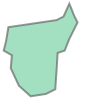

In [107]:
polygon1

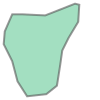

In [108]:
polygon2

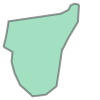

In [106]:
polygon1.intersection(polygon2)

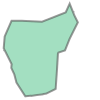

In [147]:
polygon1.union(polygon2)

In [116]:
for i in np.arange(len(img_info)):
    img_name = img_info["filename"][i]
    if 'COCO' in img_name:
        img_id = int(img_name.split('_')[-1])
        filtered_object_tbl = object_tbl[object_tbl["image_id"]==i+1]
        annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anns = coco.loadAnns(annIds)
        #for oid,bbx_path,bby_path in zip(bb_info["object_id"],bb_info["x_locs"],bb_info["y_locs"]):
        for bb in bb_info.iterrows():
            oid = bb[1]["object_id"]
            bbx_path= bb[1]["x_locs"]
            bby_path= bb[1]["y_locs"]
            if int(object_tbl[object_tbl.object_id==oid].image_id) ==i+1:
                worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
                ground_truth_match = ground_truth[ground_truth.id==str(oid)]
                COCO_id = int(ground_truth_match["COCO_annIds"])
                
                #COCO-Annotations
                for ann in anns:
                    if COCO_id==-1:
                        #No BB for this object collected by MSCOCO
                        pass
                    elif ann['id'] == COCO_id: 
#                         print COCO_id
                        for annBB in ann["segmentation"]:
                            coco_x_locs,coco_y_locs = process_raw_locs(annBB,COCO=True)
                            obj_x_locs = [worker_x_locs,coco_x_locs]
                            obj_y_locs = [worker_y_locs,coco_y_locs]
                            bb_info = bb_info.set_value(bb[0],"COCO Majority Vote",majority_vote(obj_x_locs,obj_y_locs))
                            #bb_info = bb_info.set_value(bb[0],"Munkres Euclidean",DistAllWorkers(obj_x_locs,obj_y_locs))
                            bb_info = bb_info.set_value(bb[0],"COCO Precision",precision(obj_x_locs,obj_y_locs))
                            bb_info = bb_info.set_value(bb[0],"COCO Recall",recall(obj_x_locs,obj_y_locs))                
                my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
                my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
                obj_x_locs = [worker_x_locs,my_x_locs]
                obj_y_locs = [worker_y_locs,my_y_locs]
                bb_info = bb_info.set_value(bb[0],"My Majority Vote",majority_vote(obj_x_locs,obj_y_locs))   
                bb_info = bb_info.set_value(bb[0],"My Precision",precision(obj_x_locs,obj_y_locs))
                bb_info = bb_info.set_value(bb[0],"My Recall",recall(obj_x_locs,obj_y_locs))
# replace all NAN values with -1, these are entries for which we don't have COCO ground truth
bb_info = bb_info.fillna(-1)

In [149]:
bb_info.to_csv("computed_my_COCO_BBvals.csv")

### Use Kolmogorov-Smirnov test to see how well the distributions fit a Gaussian 


In [124]:
from scipy import stats

(0, 1.05)

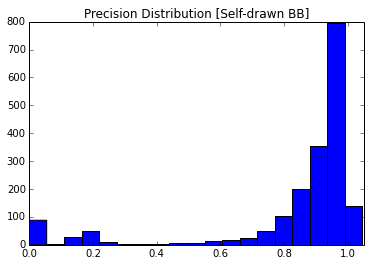

In [159]:
my_precision = np.array(bb_info["My Precision"][bb_info["My Precision"]!=-1])
plt.figure()
plt.title("Precision Distribution [Self-drawn BB]")
plt.hist(my_precision,bins=1000)
plt.xlim(0,1.05)

(0, 1.05)

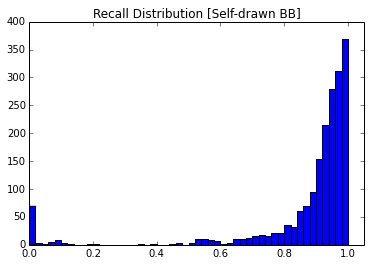

In [160]:
my_recall = np.array(bb_info["My Recall"][bb_info["My Recall"]!=-1])
plt.figure()
plt.title("Recall Distribution [Self-drawn BB]")
plt.hist(my_recall,bins=50)
plt.xlim(0,1.05)

In [161]:
print  stats.kstest(my_precision, 'norm')
print stats.kstest(my_recall, 'norm')

(0.63390175005377802, 0.0)
(0.66631878187717508, 0.0)


In [162]:
print stats.kstest(my_precision, 'expon')
print stats.kstest(my_recall, 'expon')

(0.38691067457919365, 0.0)
(0.41326489697122637, 0.0)


(0, 1.1)

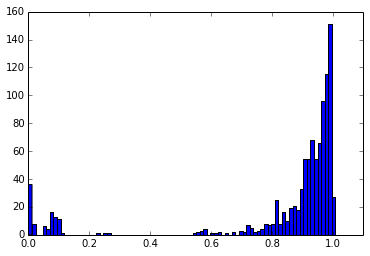

In [172]:
coco_precision = np.array(bb_info["COCO Precision"][bb_info["COCO Precision"]!=-1])
coco_recall = np.array(bb_info["COCO Recall"][bb_info["COCO Recall"]!=-1])
plt.hist(coco_precision,bins=200)
plt.xlim(0,1.1)

#### It's easier to fit f in 1-f(x) form for this dataset '

(0, 1.1)

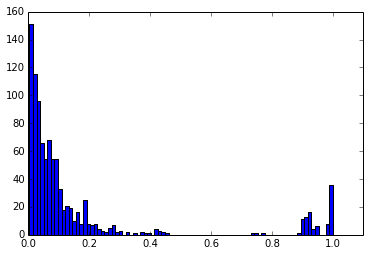

In [174]:
coco_precision = np.array(bb_info["COCO Precision"][bb_info["COCO Precision"]!=-1])
coco_recall = np.array(bb_info["COCO Recall"][bb_info["COCO Recall"]!=-1])
plt.hist(1-coco_precision,bins=200)
plt.xlim(0,1.1)

#### The null hypothesis is that the sample is not drawn from the reference distribution, so if p>0.05 then reject null hypothesis, they are drawn from that distribution. [see stats_helper.py]

In [232]:
stats.kstest(stats.norm.rvs(size=100), 'norm')

(0.055054505094351391, 0.92226833701059863)

In [236]:
def pcheck(p,null_hyp):
    '''
    if p>0.05 then reject null hypothesis
    '''
    if p>0.05:
        return  null_hyp
    else:
        return "NOT "+null_hyp

In [237]:
def one_way_kolmogorov_smirnov(data,name,distr_name):
	'''
	See if data come from the reference distribution
	'''
	result = stats.kstest(data,distr_name)
	print "{0} : D = {1} ; p ={2} ---> {3}".format(name,np.around(result[0],2),np.around(result[1],2),pcheck(result[1],"from {} distribution".format(distr_name)))

In [244]:
for test_distr in ['expon','norm']:
    print '------------------------{}------------------------'.format(test_distr)
    one_way_kolmogorov_smirnov(coco_precision,'COCO Precision',test_distr)
    one_way_kolmogorov_smirnov(coco_recall,'COCO Recall',test_distr)
    one_way_kolmogorov_smirnov(my_precision,'Self Precision',test_distr)
    one_way_kolmogorov_smirnov(my_recall,'Self Recall',test_distr)

------------------------expon------------------------
COCO Precision : D = 0.4 ; p =0.0 ---> NOT from expon distribution
COCO Recall : D = 0.43 ; p =0.0 ---> NOT from expon distribution
Self Precision : D = 0.39 ; p =0.0 ---> NOT from expon distribution
Self Recall : D = 0.41 ; p =0.0 ---> NOT from expon distribution
------------------------norm------------------------
COCO Precision : D = 0.64 ; p =0.0 ---> NOT from norm distribution
COCO Recall : D = 0.67 ; p =0.0 ---> NOT from norm distribution
Self Precision : D = 0.63 ; p =0.0 ---> NOT from norm distribution
Self Recall : D = 0.67 ; p =0.0 ---> NOT from norm distribution


In [189]:
print stats.kstest(1-coco_precision, 'pareto',args=[2])
print stats.kstest(1-coco_recall, 'pareto',args=[2])

(1.0, 0.0)
(1.0, 0.0)


In [178]:
print stats.kstest(1-coco_precision, 'powerlaw',args=[2])
print stats.kstest(1-coco_recall, 'powerlaw',args=[2])

(0.8090654868653665, 0.0)
(0.83643491334040732, 0.0)


(0, 5)

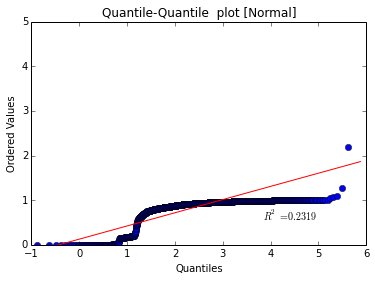

In [143]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(my_precision, dist=stats.norm, sparams=(2.5,), plot=ax)
ax.set_title("Quantile-Quantile  plot [Normal]")
ax.set_ylim(0,5)

(0, 5)

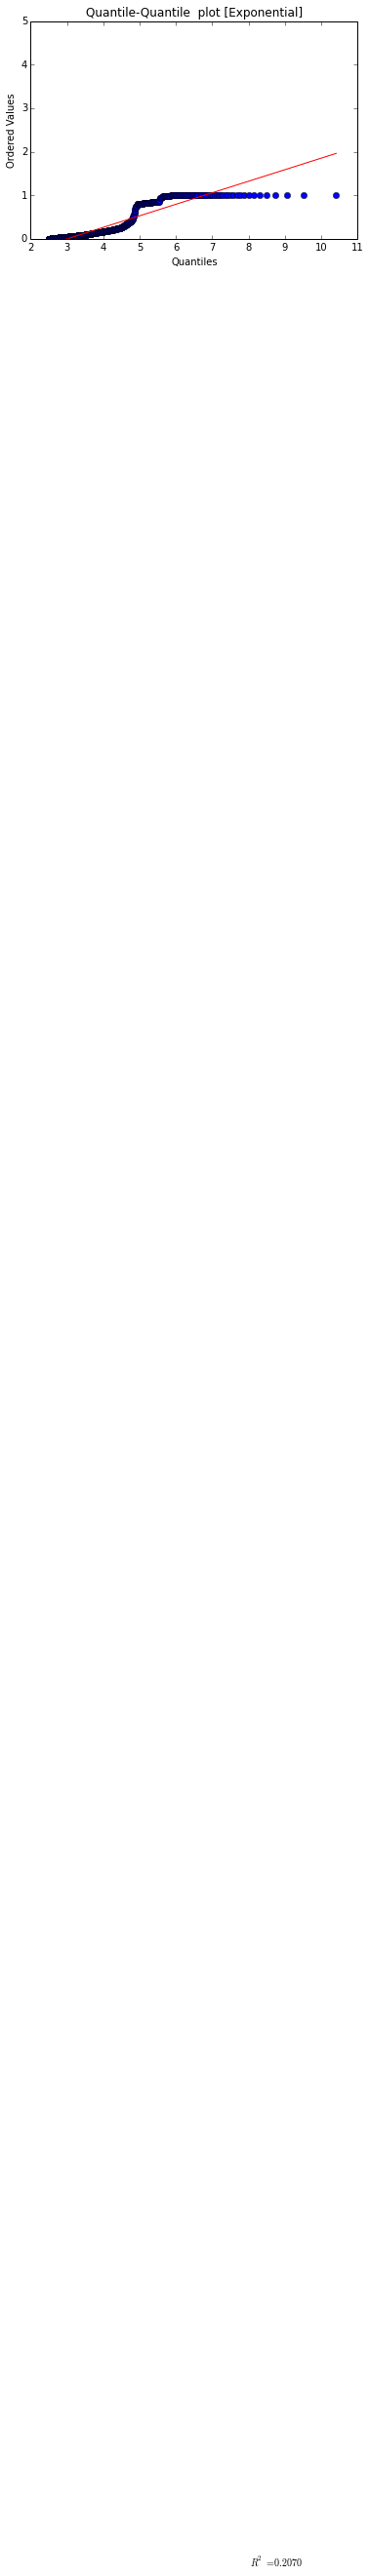

In [192]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(1-my_precision, dist=stats.expon, sparams=(2.5,), plot=ax)
ax.set_title("Quantile-Quantile  plot [Exponential]")
ax.set_ylim(0,5)

These distributions are very far from a normal or even an exponential distribution, even when you filter out the outliers 

Other quantities: boundary complexity, comparison with color mixture and hues from CV 